In [1]:
# annotations denoting beats
BEAT_CLASSIFIERS = ["N","L","R","B","A","a","J","S","V","r","F","e","j","n","E","/","f","Q","?","|"]

qrs_window_size = 10 # even numbers, so QRS is centered!
net_window_size = 50
batch_size = 128

def extract_signals(record):
    channels = len(record.p_signal[0])
    signals = []
    for channel in range(channels):
        signals.append(record.p_signal[:,channel])
    return signals

def extract_annotations(annotations):
    """Removes first element which is begin marker."""
    positions = annotations.sample[1:]
    labels = annotations.symbol[1:]
    return positions, labels

def filter_annotations(positions, labels, keep):
    """
    Filter out all annotations not denoting beats.
    Keep beat classifiers and corresponding positions.
    """
    filtered_positions = [val for idx, val in enumerate(positions) if labels[idx] in keep]
    filtered_labels = [val for idx, val in enumerate(labels) if labels[idx] in keep]
    return filtered_positions, filtered_labels

In [2]:
import numpy as np
import wfdb

path = '../data/mit-bih-nsrdb/16265'
record = wfdb.rdrecord(path)
annotations = wfdb.rdann(path, 'atr')

signals = extract_signals(record)
signal = signals[0]

ann_positions, ann_labels = extract_annotations(annotations)
ann_positions, ann_labels = filter_annotations(ann_positions, ann_labels, BEAT_CLASSIFIERS)

## Normalize Signal

In [3]:
signal = (signal - min(signal)) / (max(signal) - min(signal))

## Generate QRS Stream

In [4]:
qrs_stream = np.zeros(len(signal))

for pos in ann_positions:
    pos_start = pos - qrs_window_size // 2
    pos_end = pos + qrs_window_size // 2
    qrs_stream[pos_start:pos_end] = 1.

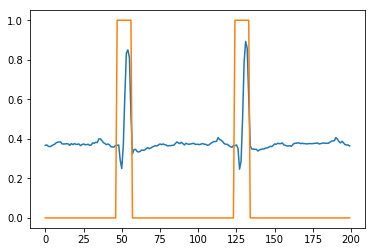

In [5]:
import matplotlib.pyplot as plt

plt.plot(signal[0:200])
plt.plot(qrs_stream[0:200])
plt.show()

## Define Data Generators

In [6]:
def generate_window(signal, qrs_stream, index, size, return_qrs=False):
    window = signal[index:index+size]
    label = qrs_stream[index + size // 2]
    if return_qrs:
        qrs_window = qrs_stream[index:index+size]
        return window, label, qrs_window
    return window, label
    
def generate_batch(signal, qrs_stream, window_size, batch_size):
    indexes = np.random.randint(low=0, high=len(signal) - window_size, size=batch_size)
    windows, labels = [], []
    for index in indexes:
        window, label = generate_window(signal, qrs_stream, index, window_size)
        windows.append(window)
        labels.append(label)
    return (
            np.array(windows).reshape(batch_size, window_size, 1),
            np.array(labels))
    
def batch_generator(signal, qrs_stream, window_size, batch_size):
    while True:
        yield generate_batch(signal, qrs_stream, window_size, batch_size)

QRS centered? --> 0.0


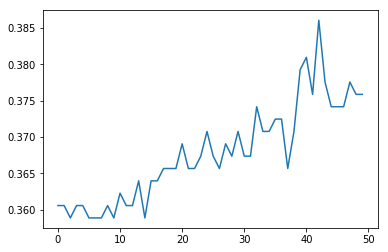

In [7]:
import matplotlib.pyplot as plt

for batch in batch_generator(signal, qrs_stream, net_window_size, 1):
    window = batch[0][0]
    label = batch[1][0]
    break

print("QRS centered? --> {}".format(label))
plt.plot(window)
plt.show()

## Train / Valid / Test Split

In [8]:
train_begin = 0
valid_begin = round(len(signal) * 0.6)
test_begin = round(len(signal) * 0.8)
end = len(signal)

train_gen = batch_generator(
    signal[train_begin:valid_begin],
    qrs_stream[train_begin:valid_begin],
    window_size = net_window_size,
    batch_size = batch_size)

valid_gen = batch_generator(
    signal[valid_begin:test_begin],
    qrs_stream[valid_begin:test_begin],
    window_size = net_window_size,
    batch_size = batch_size)

test_gen  = batch_generator(
    signal[test_begin:end],
    qrs_stream[test_begin:end],
    window_size = net_window_size,
    batch_size = batch_size)

## Build Neural Network

In [9]:
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Dropout, Flatten, MaxPooling1D

model = Sequential()
model.add(Dropout(0.5, input_shape=(net_window_size,1)))
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(3, strides=2))
model.add(Dropout(0.5))
model.add(Conv1D(32, 5, activation='relu'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 50, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 46, 32)            192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 22, 32)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 22, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 18, 32)            5152      
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 576)               0         
__________

## Train Neural Network

In [10]:
model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit_generator(
    generator=train_gen,
    epochs=10,
    steps_per_epoch=10000,
    validation_data=valid_gen,
    validation_steps=1000)

Epoch 1/10
10000/10000 [==============================] - 382s 38ms/step - loss: 0.2276 - acc: 0.9784 - val_loss: 0.3361 - val_acc: 0.9225
Epoch 2/10
10000/10000 [==============================] - 380s 38ms/step - loss: 0.2681 - acc: 0.9792 - val_loss: 0.4283 - val_acc: 0.9218
Epoch 3/10
10000/10000 [==============================] - 263s 26ms/step - loss: 0.3071 - acc: 0.9771 - val_loss: 0.6752 - val_acc: 0.9236
Epoch 4/10
10000/10000 [==============================] - 208s 21ms/step - loss: 0.3481 - acc: 0.9745 - val_loss: 0.3609 - val_acc: 0.9232
Epoch 5/10
10000/10000 [==============================] - 207s 21ms/step - loss: 0.3737 - acc: 0.9732 - val_loss: 0.6424 - val_acc: 0.9220
Epoch 6/10
10000/10000 [==============================] - 207s 21ms/step - loss: 0.4915 - acc: 0.9661 - val_loss: 0.8578 - val_acc: 0.9223
Epoch 7/10
10000/10000 [==============================] - 211s 21ms/step - loss: 0.5353 - acc: 0.9629 - val_loss: 0.5845 - val_acc: 0.9216
Epoch 8/10
10000/10000 [===

## Eval

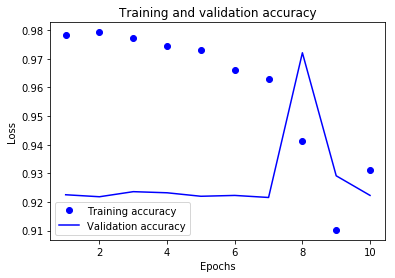

In [11]:
train_acc = history.history['acc']
valid_acc = history.history['val_acc']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, valid_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
x, y = [], []
for i in range(1,1000):
    windows, labels = test_gen.__next__()
    x.extend(windows)
    y.extend(labels)

x = np.array(x)
y = np.array(y)
    
predictions = model.predict_classes(x, batch_size=batch_size)

Confusion matrix, without normalization
[[124126      1]
 [  3740      5]]


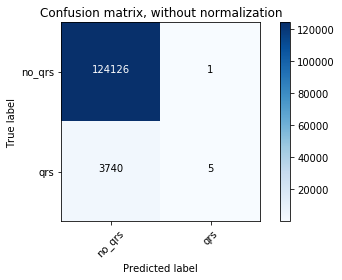

Normalized confusion matrix
[[9.99991944e-01 8.05626495e-06]
 [9.98664887e-01 1.33511348e-03]]


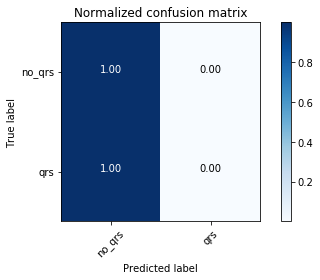

In [13]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
cm = confusion_matrix(y, predictions)

plt.figure()
plot_confusion_matrix(cm, classes=['no_qrs', 'qrs'], title='Confusion matrix, without normalization')
plt.show()

plt.figure()
plot_confusion_matrix(cm, classes=['no_qrs', 'qrs'], normalize=True, title='Normalized confusion matrix')
plt.show()